In [1]:
import subprocess
import pandas as pd
import numpy as np
import itertools
from itertools import chain
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("cork.txt")
cork_map = LinearSegmentedColormap.from_list("cork", cm_data)

In [2]:
nbelts = 36

## Latitudinal temperature profiles

['1'] 0. 2.5 ['1.0'] ['0.7'] ['1'] F0 1.5 0.001
Final atmospheric CO2 atmospheric pressure = 9.99462E-01
Minimum temperatures [151.735 156.113 159.488 160.749 173.437 186.395 193.965 199.886 209.385
 217.588 224.584 230.495 235.411 239.482 242.694 245.113 246.748 247.594
 247.647 246.788 245.109 242.653 239.418 235.372 230.47  224.568 217.577
 209.379 199.881 195.247 188.697 174.327 158.723 155.923 153.453 150.939]
Fraction of CO2 lost to the surface = 0.05
['1'] 0. 1.25 ['1.0'] ['0.7'] ['1'] Sun 1.0 0.001
Final atmospheric CO2 atmospheric pressure = 9.99647E-01
Minimum temperatures [176.975 181.983 187.57  191.671 194.063 200.003 207.413 214.649 221.485
 227.759 233.419 238.451 242.865 246.629 249.746 252.172 253.854 254.754
 254.84  253.91  252.139 249.633 246.458 242.709 238.341 233.34  227.701
 221.441 214.615 207.386 199.981 194.173 190.624 184.998 179.713 176.158]
Fraction of CO2 lost to the surface = 0.04
['1'] 0. 0.53 ['1.0'] ['0.7'] ['1'] K5 0.6 0.001
Final atmospheric CO2 atm

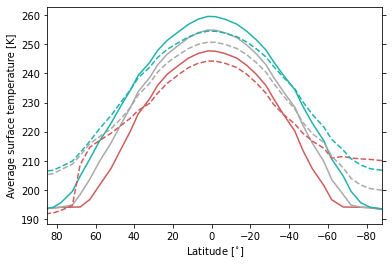

In [3]:
# What is the temperature gradient across the planet?
start = ["Cold"] 
STAR = ["F0","Sun","K5"] 
smass = ["1.5","1.0","0.6"]

#a0 = ["2.7","1.4","0.6"]     # For Figure 5 in the paper

# Figure 4
#a0 = ["2.2","1.1","0.45"]     # Low
#a0 = ["2.4","1.25","0.53"]     # Intermediate (Figure 4)
a0 = ["2.5","1.25","0.53"]
#a0 = ["2.75","1.42","0.6"]    # High

obl = ["0.","23.5"]
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["1.0"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

temp_ave = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
latitude_plot = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
CO2_ice = np.zeros((nbelts,len(a0)*2),dtype=np.float32)


s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for b in range(len(obl)):
    for c in range(len(STAR)):
            if b==0:
                #val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            else:
                # val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            print (icoldflag,obl[b],a0[c],pco2i,ocean,igeog,STAR[c],smass[c],val[c])
            
            with open("input_ebm.dat", "r") as f:
                main = f.read()
                for j, line in enumerate(splitfile):
                    if var[0] in line:
                        splitfile[j] = 'icoldflag:       %s' % icoldflag[0]
                    if var[1] in line:
                        splitfile[j] = 'obl:             %s' % obl[b]
                    if var[2] in line:
                        splitfile[j] = 'a0:              %s' % a0[c]            
                    if var[3] in line:
                        splitfile[j] = 'pco2i:           %s' % pco2i[0] 
                    if var[4] in line:
                        splitfile[j] = 'ocean:           %s' % ocean[0]            
                    if var[5] in line:
                        splitfile[j] = 'igeog:           %s' % igeog[0]   
                    if var[6] in line:
                        splitfile[j] = 'STAR:      %s' % STAR[c]
                    if var[7] in line:
                        splitfile[j] = 'smass:           %s' % smass[c]    
                    if var[8] in line:
                        splitfile[j] = 'val:     %s' % val[c] 
        
                with open("input_ebm.dat", "w") as f:
                    f.write('\n'.join(splitfile))              

        
                if j==0:
                    subprocess.call(['make clean'], shell=True)
                    subprocess.call(['make'], shell=True)
            
                subprocess.call(['./driver'],shell=True)
            
    
                df = pd.read_csv('out/model.out', header=None)
                df = pd.DataFrame(df[0].str.split(' ').tolist())
        
                #Average temperature from text file
                temp_av = df.iloc[56:72,14]
                temp_av = temp_av.append(df.iloc[72:74,15])
                temp_av = temp_av.append(df.iloc[74:76,16])
                temp_av = temp_av.append(df.iloc[76:92,15])
                temp_av = np.array(temp_av, dtype = np.float32)
                
                pCO2_final = df.iloc[47,8]
                print ("Final atmospheric CO2 atmospheric pressure =", pCO2_final)
                
                #Minimum temperature from text file
                temp_min = df.iloc[56:72,20]
                temp_min = temp_min.append(df.iloc[72:74,21])
                temp_min = temp_min.append(df.iloc[74:76,22])
                temp_min = temp_min.append(df.iloc[76:92,21])
                temp_min = np.array(temp_min, dtype = np.float32)
                
                print ("Minimum temperatures", temp_min)
                
                latitude = df.iloc[56:72,4]
                latitude = latitude.append(df.iloc[72:74,5])
                latitude = latitude.append(df.iloc[74:76,6])
                latitude = latitude.append(df.iloc[76:92,5])
                latitude = np.array(latitude, dtype = np.float32)
                
                temp_ave[:,n] = temp_av
                latitude_plot[:,n]=latitude
                
                # CO2 surface ice
                for m in range(len(df)):
                    if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                        CO2_ice[n,s] = df.iloc[m,10]
                        break
                    elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                        CO2_ice[n,s] = df.iloc[m,9]
                    if CO2_ice[n,s]<0:
                        exit
                        break
                print ("Fraction of CO2 lost to the surface =", CO2_ice[n,s]) 

                n+=1

colori=["indianred","darkgrey","lightseagreen","indianred","darkgrey","lightseagreen"]
style = ["-","-","-","--","--","--"]
labello=["F0 star", "Sun", "K5 star"]

plt.figure(6)
for i in range(temp_ave.shape[1]):
    
    latitude = latitude_plot[:,i]
    latitude_pole1 = latitude[:-32]
    latitude_pole2 = latitude[32:]
    latitude_eq = latitude_plot[3:-3]

    temp_ave_plot = temp_ave[:,i]
    temp_ave_pole1 = temp_ave_plot[:-32]
    temp_ave_pole2 = temp_ave_plot[32:]
    temp_ave_eq = temp_ave_plot[3:-3]
    
    if i!=7:
        plt.plot(latitude,temp_ave_plot,color=colori[i],linestyle=style[i])
    else:   
        plt.plot(latitude_pole1,temp_ave_pole1,color=colori[i],linestyle=':')
        plt.plot(latitude_pole2,temp_ave_pole2,color=colori[i],linestyle=':')
        plt.plot(latitude_eq,temp_ave_eq,color=colori[i],linestyle=style[i])

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

# simArtist = plt.Line2D((0,1),(0,0), color='k')
# anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')

# plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
#           [label for i,label in enumerate(labels) if i in display]+['$0^{\circ}$','$23.5^{\circ}$'],bbox_to_anchor=(0.81, 0.7),borderaxespad=0.,fontsize=8)
# plt.legend(bbox_to_anchor=(1.25, 1.01))
#plt.legend()
plt.xlabel("Latitude [$^{\circ}$]")
plt.ylabel("Average surface temperature [K]")
ax.yaxis.set_ticks_position('both')
plt.xlim([85, -88])
plt.savefig('Figures/T_ave_icold{}_a{}.pdf'.format(icoldflag[0],a0[0]), bbox_inches='tight',format='pdf')
plt.show()

## Amount of condensed CO2 ice

In [5]:
# How much CO_{2} for a given initial atmospheric pressure?
icoldflag = ["1"]
start = ["Cold"] # "Cold" or "Warm"
STAR = ["F0","Sun","K5"] # "Sun" or "K5"
smass = ["1.5","1.","0.6"]
#a0 = ["2.7","1.4","0.6"] # was 2.7 to reproduce first paper draft
a0 = ["2.5","1.25","0.53"]
obl = ["0","23.5"]

ocean = ["0.7"]
igeog = ["1"]
pco2i = ["3.0","2.5","2.0","1.5","1.0","0.5","0.1","0.01"]
#pco2i = ["3.0","2.75","2.5","2.25","2.0","1.75","1.5","1.25","1.0","0.75","0.5","0.25","0.1","0.05","0.01"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]
    
a_max = max(float(sub) for sub in a0) 
a_min = min(float(sub) for sub in a0)    

sem_ax = len(a0)  
pco2 = len(pco2i)

pco2_plot = [3,2.5,2,1.5,1,0.5,0.1,0.01]
pco2_plot = np.array([pco2_plot,]*sem_ax*2).transpose()

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

gl = np.zeros((len(pco2i),len(a0)*2),dtype=np.float32)
CO2_ice = np.zeros((len(pco2i),len(a0)*2),dtype=np.float32)
temp_ave = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
latitude_plot = np.zeros((nbelts,len(a0)*2),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for b in range(len(obl)):
    
    
    if b==0:
        #val=["0.35","0.35","0.35"]
        val=["0.001","0.001","0.001"]
    else:
        #val=["0.35","0.35","0.35"]
        val=["0.001","0.001","0.001"]
    
    for c in range(len(STAR)):
        for d in range(len(pco2i)):
            print (icoldflag,obl[b],a0[c],pco2i[d],ocean,igeog,STAR[c],smass[c],val[c])
                
            with open("input_ebm.dat", "r") as f:
                main = f.read()
                for j, line in enumerate(splitfile):
                    if var[0] in line:
                        splitfile[j] = 'icoldflag:       %s' % icoldflag[0]
                    if var[1] in line:
                        splitfile[j] = 'obl:             %s' % obl[b]
                    if var[2] in line:
                        splitfile[j] = 'a0:              %s' % a0[c]            
                    if var[3] in line:
                        splitfile[j] = 'pco2i:           %s' % pco2i[d] 
                    if var[4] in line:
                        splitfile[j] = 'ocean:           %s' % ocean[0]            
                    if var[5] in line:
                        splitfile[j] = 'igeog:           %s' % igeog[0]   
                    if var[6] in line:
                        splitfile[j] = 'STAR:      %s' % STAR[c]
                    if var[7] in line:
                        splitfile[j] = 'smass:           %s' % smass[c] 
                    if var[8] in line:
                        splitfile[j] = 'val:     %s' % val[c] 
                        
                with open("input_ebm.dat", "w") as f:
                    f.write('\n'.join(splitfile))              

        
                if j==0:
                    subprocess.call(['make clean'], shell=True)
                    subprocess.call(['make'], shell=True)
            
                subprocess.call(['./driver'],shell=True)
            
    
                df = pd.read_csv('out/model.out', header=None)
                df = pd.DataFrame(df[0].str.split(' ').tolist())
        
                # CO2 surface ice
                for m in range(len(df)):
                    if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                        CO2_ice[n,s] = df.iloc[m,10]
                        break
                    elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                        CO2_ice[n,s] = df.iloc[m,9]
                    if CO2_ice[n,s]<0:
                        exit
                        break
                print (CO2_ice[n,s])                
        
                #Average temperature from text file
                temp_av = df.iloc[56:72,14]
                temp_av = temp_av.append(df.iloc[72:74,15])
                temp_av = temp_av.append(df.iloc[74:76,16])
                temp_av = temp_av.append(df.iloc[76:92,15])
                temp_av = np.array(temp_av, dtype = np.float32)
                
                latitude = df.iloc[56:72,4]
                latitude = latitude.append(df.iloc[72:74,5])
                latitude = latitude.append(df.iloc[74:76,6])
                latitude = latitude.append(df.iloc[76:92,5])
                latitude = np.array(latitude, dtype = np.float32)
                
                temp_ave[:,s] = temp_av
                latitude_plot[:,s]=latitude
                
            if n==7:
                n=n-7
                s+=1
            else:
                n+=1

['1'] 0 2.5 3.0 ['0.7'] ['1'] F0 1.5 0.001
0.012
['1'] 0 2.5 2.5 ['0.7'] ['1'] F0 1.5 0.001
0.017
['1'] 0 2.5 2.0 ['0.7'] ['1'] F0 1.5 0.001
0.034
['1'] 0 2.5 1.5 ['0.7'] ['1'] F0 1.5 0.001
0.081
['1'] 0 2.5 1.0 ['0.7'] ['1'] F0 1.5 0.001
0.079
['1'] 0 2.5 0.5 ['0.7'] ['1'] F0 1.5 0.001
7.891
['1'] 0 2.5 0.1 ['0.7'] ['1'] F0 1.5 0.001
9.64
['1'] 0 2.5 0.01 ['0.7'] ['1'] F0 1.5 0.001
3.718
['1'] 0 1.25 3.0 ['0.7'] ['1'] Sun 1. 0.001
0.007
['1'] 0 1.25 2.5 ['0.7'] ['1'] Sun 1. 0.001
0.03
['1'] 0 1.25 2.0 ['0.7'] ['1'] Sun 1. 0.001
0.044
['1'] 0 1.25 1.5 ['0.7'] ['1'] Sun 1. 0.001
0.098
['1'] 0 1.25 1.0 ['0.7'] ['1'] Sun 1. 0.001
7.803
['1'] 0 1.25 0.5 ['0.7'] ['1'] Sun 1. 0.001
3.905
['1'] 0 1.25 0.1 ['0.7'] ['1'] Sun 1. 0.001
1.837
['1'] 0 1.25 0.01 ['0.7'] ['1'] Sun 1. 0.001
3.345
['1'] 0 0.53 3.0 ['0.7'] ['1'] K5 0.6 0.001
0.011
['1'] 0 0.53 2.5 ['0.7'] ['1'] K5 0.6 0.001
0.013
['1'] 0 0.53 2.0 ['0.7'] ['1'] K5 0.6 0.001
0.769
['1'] 0 0.53 1.5 ['0.7'] ['1'] K5 0.6 0.001
0.808
['1'] 0 

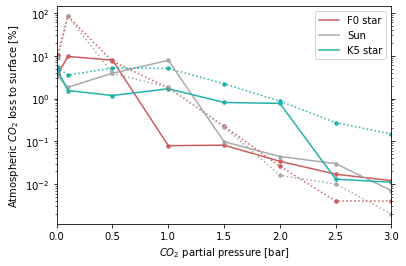

In [6]:
# pco2_plot = [3,2.75,2.5,2.25,2,1.75,1.5,1.25,1,0.75,0.5,0.25,0.1,0.05,0.01]
# pco2_plot = np.array([pco2_plot,]*sem_ax*2).transpose()

colori=["indianred","darkgrey","lightseagreen","indianred","darkgrey","lightseagreen"]
style = ["-","-","-",":",":",":"]
labello=["F0 star", "Sun", "K5 star"]

plt.figure(5)
for i in range(pco2_plot.shape[1]):
    if i==0 or i==1 or i==2:
        plt.plot(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],linestyle=style[i],label=labello[i])
    else:
        plt.plot(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],linestyle=style[i])
    plt.scatter(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],s=12)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

simArtist = plt.Line2D((0,1),(0,0), color='k')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')

plt.legend()
plt.semilogy()
plt.xlabel("$CO_{\mathrm{2}}$ partial pressure [bar]")
plt.ylabel("Atmospheric $CO_{\mathrm{2}}$ loss to surface [%]")
ax.yaxis.set_ticks_position('both')
plt.xlim([0,3])
plt.savefig('CO2_ice.pdf', bbox_inches='tight',format='pdf')
plt.show()

In [7]:
# We only have to change these 3 parameters
start = ["Cold"] # "Cold" or "Warm"
STAR = ["Sun"]   # "Sun" or "K5" or "F0"
obl = ["23.5"]
val = ["0.001"] # Sun --> 0.05 K5 --> 0.04 or 0.05 F0 --> 0.035,0.065 (cold start), 0.05 (warm start) 

# Other parameters
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["3.00","2.75","2.5","2.25","2.0","1.75","1.5","1.25","1.0","0.75","0.5","0.25","0.1","0.05","0.01"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]

if STAR == ["Sun"]:
    smass = ["1.0"]
    a0 = ["1.00","1.025","1.05","1.075","1.10","1.125","1.15","1.175","1.20","1.225","1.25","1.275","1.30","1.325","1.35","1.375","1.40","1.425","1.45","1.475","1.5"]
elif STAR == ["K5"]:
    smass = ["0.6"]
    # Need to change 0.49 for K5 warm
    a0 = ["0.40","0.41","0.42","0.43","0.44","0.45","0.46","0.47","0.48","0.491","0.5","0.51","0.52","0.53","0.54","0.55","0.56","0.57","0.58","0.59","0.6"]
else:
    smass = ["1.5"]
    a0 = ["2.00","2.05","2.10","2.15","2.20","2.25","2.30","2.35","2.40","2.45","2.50","2.55","2.601","2.65","2.70","2.75","2.80","2.85","2.90","2.95","3.00"]
    
a_max = max(float(sub) for sub in a0) 
a_min = min(float(sub) for sub in a0)
pco2_max = max(float(sub) for sub in pco2i) 
pco2_min = min(float(sub) for sub in pco2i)     

sem_ax = len(a0)  
pco2 = len(pco2i)

sem_ax_plot = np.linspace(a_min,a_max,sem_ax)
sem_ax_plot = np.reshape(sem_ax_plot, (sem_ax))
sem_ax_plot = np.array([sem_ax_plot,]*pco2)

pco2_plot = [3,2.75,2.5,2.25,2,1.75,1.5,1.25,1,0.75,0.5,0.25,0.1,0.05,0.01]
pco2_plot = np.array([pco2_plot,]*sem_ax).transpose()

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

gl = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
points = np.zeros((len(pco2i)+len(a0),2),dtype=np.float32)
text = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
CO2_ice = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
Delta_T = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
T_min = np.zeros((len(pco2i),len(a0)),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]  

for i in itertools.product(icoldflag,obl,a0,pco2i,ocean,igeog,STAR,smass,val):
    
    a,b,c,d,e,f,g,h,k = i            
    print (i)
    
    with open("input_ebm.dat", "r") as f:
        main = f.read()
        for j, line in enumerate(splitfile):
            if var[0] in line:
                splitfile[j] = 'icoldflag:       %s' % i[0]
            if var[1] in line:
                splitfile[j] = 'obl:             %s' % i[1]
            if var[2] in line:
                splitfile[j] = 'a0:              %s' % i[2]            
            if var[3] in line:
                splitfile[j] = 'pco2i:           %s' % i[3] 
            if var[4] in line:
                splitfile[j] = 'ocean:           %s' % i[4]            
            if var[5] in line:
                splitfile[j] = 'igeog:           %s' % i[5]   
            if var[6] in line:
                splitfile[j] = 'STAR:      %s' % i[6]
            if var[7] in line:
                splitfile[j] = 'smass:           %s' % i[7] 
            if var[8] in line:
                splitfile[j] = 'val:     %s' % i[8] 
        
        with open("input_ebm.dat", "w") as f:
            f.write('\n'.join(splitfile))
        
        if j==0:
            subprocess.call(['make clean'], shell=True)
            subprocess.call(['make'], shell=True)             
        subprocess.call(['./driver'],shell=True)
    
        df = pd.read_csv('out/model.out', header=None)
        df = pd.DataFrame(df[0].str.split(' ').tolist())
        
        # CO2 surface ice
        for m in range(len(df)):
            if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                CO2_ice[n,s] = df.iloc[m,10]
                break
            elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                CO2_ice[n,s] = df.iloc[m,9]
                break
        if CO2_ice[n,s]<0:
            CO2_ice[n,s] = 0.  
        
        #Average temperature from text file
        temp_av = df.iloc[56:72,14]
        temp_av = temp_av.append(df.iloc[72:74,15])
        temp_av = temp_av.append(df.iloc[74:76,16])
        temp_av = temp_av.append(df.iloc[76:92,15])
        temp_av = np.array(temp_av, dtype = np.float32)
        
        #Minimum temperature from text file
        temp_min = df.iloc[56:72,20]
        temp_min = temp_min.append(df.iloc[72:74,21])
        temp_min = temp_min.append(df.iloc[74:76,22])
        temp_min = temp_min.append(df.iloc[76:92,21])
        temp_min = np.array(temp_min, dtype = np.float32)
        
        #Maximum temperature from text file
        temp_max = df.iloc[56:72,26]
        temp_max = temp_max.append(df.iloc[72:74,27])
        temp_max = temp_max.append(df.iloc[74:76,28])
        temp_max = temp_max.append(df.iloc[76:92,27])
        temp_max = np.array(temp_min, dtype = np.float32)

        # 1: Snowball planet, 4: Ice-free planets, 2: Partially ice-free with CO2  3: Partially ice free with no CO2
        if all(i < 263 for i in temp_av) and CO2_ice[n,s]>0.:
            gl[n, s] = 1 # blue
            print ('Surface temperatures all below 263, blue')
        elif all(k > 263 for k in temp_av):
            gl[n,s] = 4 # red
            print ('Ice-free, red')
            # For F0 star at close distances 
            CO2_ice[n,s] = 0. 
                
        else:
            
            if any(p<216.6 for p in temp_av) and CO2_ice[n,s]>0.:
                gl[n,s] = 2
                print ('Ice with CO2 condensation, light blue')
            else:
                gl[n,s] = 3
                print ('Some ice but no CO2 condensation, light red')
                CO2_ice[n,s] = 0.
        if CO2_ice[n,s] >0. and CO2_ice[n,s]<0.02:
            CO2_ice[n,s] = 0.02
        print (CO2_ice[n,s])
        
    if n==14:
        n=n-14
        s+=1
    else:
        n+=1

('1', '23.5', '1.00', '3.00', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '2.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '2.5', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '2.25', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '2.0', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '1.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '1.5', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '1.25', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '1.0', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '0.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '0.5', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.00', '0.25', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23

Ice-free, red
0.0
('1', '23.5', '1.15', '2.0', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '1.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '1.5', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '1.25', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '1.0', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '0.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.15', '0.5', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
1.4
('1', '23.5', '1.15', '0.25', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
2.23
('1', '23.5', '1.15', '0.1', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
2.65
('1', '23.5', '1.15', '0.05', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
2.87
('1', '23.5', '1.15', '0.01', '0.7', '1', 'Sun

Surface temperatures all below 263, blue
2.82
('1', '23.5', '1.30', '3.00', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.30', '2.75', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.30', '2.5', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.30', '2.25', '0.7', '1', 'Sun', '1.0', '0.001')
Ice-free, red
0.0
('1', '23.5', '1.30', '2.0', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
0.08
('1', '23.5', '1.30', '1.75', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
0.16
('1', '23.5', '1.30', '1.5', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
0.53
('1', '23.5', '1.30', '1.25', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
0.83
('1', '23.5', '1.30', '1.0', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
1.36
('1', '23.5', '1.30', '0.75', '0.7', '1', 'Sun', '1.0', '0.001')
Surfac

Surface temperatures all below 263, blue
7.4
('1', '23.5', '1.425', '2.75', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
5.73
('1', '23.5', '1.425', '2.5', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
5.88
('1', '23.5', '1.425', '2.25', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
4.29
('1', '23.5', '1.425', '2.0', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
3.12
('1', '23.5', '1.425', '1.75', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
2.26
('1', '23.5', '1.425', '1.5', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
0.69
('1', '23.5', '1.425', '1.25', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
1.27
('1', '23.5', '1.425', '1.0', '0.7', '1', 'Sun', '1.0', '0.001')
Surface temperatures all below 263, blue
1.9
('1', '23.5', '1.425', '0.75', '0.7', '1', 'Sun', '1.0', '0.001'

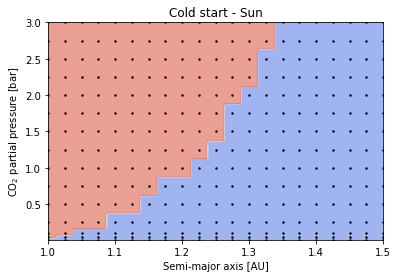

<ipython-input-8-ba56b2c96630>:83: UserWarning: Log scale: values of z <= 0 have been masked
  sc =plt.contourf(xi,yi,zice,levels=lev_CO2,cmap="viridis_r", alpha=0.6,norm=colors.LogNorm(vmin=0.001, vmax=100))


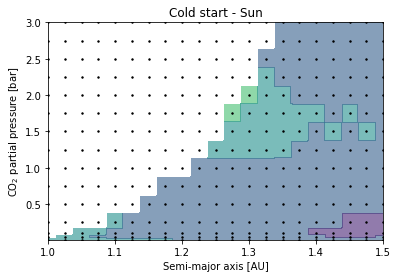

In [8]:
from matplotlib.colors import ListedColormap, BoundaryNorm
sa_plot = np.reshape(sem_ax_plot, (len(sem_ax_plot[0])*len(sem_ax_plot),1))
pc_plot = np.reshape(pco2_plot, (len(pco2_plot[0])*len(pco2_plot),1))
gl0 = np.reshape(gl, (len(gl[0])*len(gl),1))
ice = np.reshape(CO2_ice, (len(gl[0])*len(gl),1))
points = np.column_stack((sa_plot,pc_plot))

xi,yi = np.mgrid[a_min:a_max:200j, pco2_min:pco2_max:200j]

STAR = ["Sun"]

if STAR==["K5"]:        
    STAR = ["K5 star"]
    if start == ["Warm"]:
        gl_K5warm = gl0
        zi = griddata(points, gl_K5warm, (xi, yi), method="nearest").reshape(200, 200)
        ice_K5warm = ice
        zice = griddata(points, ice_K5warm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        gl_K5cold = gl0
        zi = griddata(points, gl_K5cold, (xi, yi), method="nearest").reshape(200, 200)
        ice_K5cold = ice
        zice = griddata(points, ice_K5cold, (xi, yi), method="nearest").reshape(200, 200)
    lev_CO2 = [0.01,0.1,1,10,100]

if STAR==["Sun"]:        
    if start == ["Warm"]:
        gl_Sunwarm = gl0
        zi = griddata(points, gl_Sunwarm, (xi, yi), method="nearest").reshape(200, 200)
        ice_Sunwarm = ice
        zice = griddata(points, ice_Sunwarm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        gl_Suncold = gl0
        zi = griddata(points, gl_Suncold, (xi, yi), method="nearest").reshape(200, 200) 
        ice_Suncold = ice
        zice = griddata(points, ice_Suncold, (xi, yi), method="nearest").reshape(200, 200)
    lev_CO2 = [0.01,0.1,1,10,100]
        
if STAR==["F0"]:        
    STAR = ["F0 star"]
    if start == ["Warm"]:
        gl_F0warm = gl0
        zi = griddata(points, gl_F0warm, (xi, yi), method="nearest").reshape(200, 200)
        ice_F0warm = ice
        zice = griddata(points, ice_F0warm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        gl_F0cold = gl0
        zi = griddata(points, gl_F0cold, (xi, yi), method="nearest").reshape(200, 200) 
        ice_F0cold = ice
        zice = griddata(points, ice_F0cold, (xi, yi), method="nearest").reshape(200, 200)
    lev_CO2 = [0.01,0.1,1,10,100]
    
zi = np.around(zi)

size =2
ax=plt.gca()#colors = ["blue","grey","red","green"]

plt.figure(1)
plt.contourf(xi,yi,zi,levels=[0,1,2,3,4],cmap="coolwarm", alpha=0.6)
plt.scatter(sem_ax_plot,pco2_plot,color='black', s=size)
plt.xlabel('Semi-major axis [AU]')
plt.ylabel('CO$_{2}$ partial pressure [bar]')
plt.xlim([a_min,a_max])
plt.ylim([0.01,3])
if obl == ["0"]:
    plt.title('{} start - {} %.0f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))
else:
    plt.title('{} start - {} %.1f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))  
    plt.title('{} start - {}'.format(start[0],STAR[0]))  
if STAR==["K5 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
if STAR==["F0 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.savefig('Figures/{}_{}_%.1f.pdf'.format(start[0],STAR[0]) %(np.float(obl[0])), bbox_inches='tight',format='pdf')
plt.show()

plt.figure(2)
ax=plt.gca()
sc =plt.contourf(xi,yi,zice,levels=lev_CO2,cmap="viridis_r", alpha=0.6,norm=colors.LogNorm(vmin=0.001, vmax=100))
plt.scatter(sem_ax_plot,pco2_plot,color='black', s=size)
#cb = plt.colorbar(sc,orientation='horizontal')
#cb.set_label('Atmospheric $CO_{2}$ loss to surface [%]')
plt.xlabel('Semi-major axis [AU]')
plt.ylabel('CO$_{2}$ partial pressure [bar]')
plt.xlim([a_min,a_max])
plt.ylim([0.01,3])
if obl == ["0"]:
    plt.title('{} start - {} %.0f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))
else:
    plt.title('{} start - {} %.1f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))  
    plt.title('{} start - {}'.format(start[0],STAR[0]))  
if STAR==["K5 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
if STAR==["F0 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.savefig('Figures/ice{}_{}_%.1f.pdf'.format(start[0],STAR[0]) %(np.float(obl[0])), bbox_inches='tight',format='pdf')
plt.show()

In [68]:
np.max(zice)

2.91

## Hoffman Figure 8A comparison

242.159
219.784


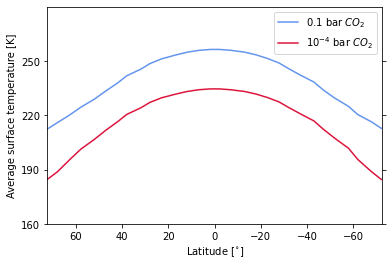

In [56]:
filenames = ['out/hoffman0.1.out','out/hoffman1e-4.out']
labels = ["0.1 bar $CO_{2}$", "$10^{-4}$ bar $CO_{2}$"]
colors = ["cornflowerblue","crimson"]

plt.figure()
for i in range(len(filenames)):
    df = pd.read_csv(filenames[i], header=None)
    df = pd.DataFrame(df[0].str.split(' ').tolist())
        
    #Average temperature from text file
    temp_av = df.iloc[56:72,14]
    temp_av = temp_av.append(df.iloc[72:74,15])
    temp_av = temp_av.append(df.iloc[74:76,16])
    temp_av = temp_av.append(df.iloc[76:92,15])
    temp_av = np.array(temp_av, dtype = np.float32)
                
    temp_av_value = df.iloc[42,7]
    print (temp_av_value)

    latitude = df.iloc[56:72,4]
    latitude = latitude.append(df.iloc[72:74,5])
    latitude = latitude.append(df.iloc[74:76,6])
    latitude = latitude.append(df.iloc[76:92,5])
    latitude = np.array(latitude, dtype = np.float32)
    
    plt.plot(latitude,temp_av,color=colors[i],label=labels[i])
plt.legend()
plt.xlabel("Latitude [$^{\circ}$]")
plt.ylabel("Average surface temperature [K]")
plt.xlim([72.5, -72.5])
plt.ylim([160,280])
plt.yticks(np.arange(160, 280, 30))
ax = plt.gca()
ax.yaxis.set_ticks_position('both')
plt.savefig('Figures/Hoffman_comparison.pdf', bbox_inches='tight',format='pdf')
plt.show()

## CO2 phase curve

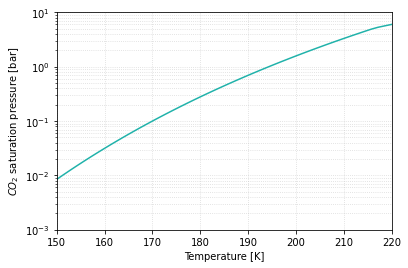

In [22]:
T = np.linspace(150,220,50)
PSL = np.zeros((len(T),1),dtype=np.float64)

for j in range(len(T)):
    if T[j]<216.56:
        PSL[j] = 6.760956 - 1284.07/(T[j] - 4.718) + 1.256e-4*(T[j] - 143.15)
    else:
        PSL[j] = 3.128082 - 867.2124/T[j] + 1.865612E-2*T[j] - 7.248820E-5*T[j]**2 + 9.3e-8*T[j]**3
        
        
PATM = 10.**PSL
PSCO2 = 1.013*PATM

plt.figure()
plt.semilogy(T,PSCO2,color='lightseagreen') 
plt.xlabel('Temperature [K]')
plt.ylabel('$CO_{2}$ saturation pressure [bar]')
plt.grid(which='both',linestyle=':',alpha=0.5)
plt.ylim([1e-3,10])
plt.xlim([150,220])
plt.savefig('Figures/CO2_phasecurve.pdf', bbox_inches='tight',format='pdf')
plt.show()

## Figure 6

In [22]:
# We only have to change these 3 parameters
start = ["Cold"] # "Cold" or "Warm"
STAR = ["F0"]    # "Sun" or "K5" or "F0"
obl = ["23.5"]
val = ["0.001"]  

# Other parameters
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["3.","1.","0.5","0.1","0.01"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]

if STAR == ["Sun"]:
    smass = ["1.0"]
    a0 = ["1.00","1.025","1.05","1.075","1.10","1.125","1.15","1.175","1.20","1.225","1.25","1.275","1.30","1.325","1.35","1.375","1.40","1.425","1.45","1.475","1.5","1.6","1.7","1.8","1.9","2"]
elif STAR == ["K5"]:
    smass = ["0.6"]
    a0 = ["0.40","0.41","0.42","0.43","0.44","0.45","0.46","0.47","0.48","0.4901","0.5","0.51","0.52","0.53","0.54","0.55","0.56","0.57","0.58","0.59","0.6","0.7","0.8","0.9","1"]
else:
    smass = ["1.5"]
    a0 = ["2.00","2.05","2.10","2.15","2.20","2.25","2.30","2.35","2.40","2.45","2.50","2.55","2.60","2.65","2.70","2.75","2.80","2.85","2.90","2.95","3.00","3.5","4","4.5","5"]

sem_ax = len(a0)  
pco2 = len(pco2i)

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

CO2_atm = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
a0_plot = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
pco2_plot = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for i in itertools.product(icoldflag,obl,a0,pco2i,ocean,igeog,STAR,smass,val):
    
    a,b,c,d,e,f,g,h,k = i            
    print (i)
    
    with open("input_ebm.dat", "r") as f:
        main = f.read()
        for j, line in enumerate(splitfile):
            if var[0] in line:
                splitfile[j] = 'icoldflag:       %s' % i[0]
            if var[1] in line:
                splitfile[j] = 'obl:             %s' % i[1]
            if var[2] in line:
                splitfile[j] = 'a0:              %s' % i[2]            
            if var[3] in line:
                splitfile[j] = 'pco2i:           %s' % i[3] 
            if var[4] in line:
                splitfile[j] = 'ocean:           %s' % i[4]            
            if var[5] in line:
                splitfile[j] = 'igeog:           %s' % i[5]   
            if var[6] in line:
                splitfile[j] = 'STAR:      %s' % i[6]
            if var[7] in line:
                splitfile[j] = 'smass:           %s' % i[7] 
            if var[8] in line:
                splitfile[j] = 'val:     %s' % i[8] 
        
        with open("input_ebm.dat", "w") as f:
            f.write('\n'.join(splitfile))
        
        if j==0:
            subprocess.call(['make clean'], shell=True)
            subprocess.call(['make'], shell=True)
            
        subprocess.call(['./driver'],shell=True)
    
        df = pd.read_csv('out/model.out', header=None)
        df = pd.DataFrame(df[0].str.split(' ').tolist())
        
        a0_plot[n,s] = i[2]
        pco2_plot[n,s] = np.float(i[3])
        print (a0_plot[n,s])
        CO2_atm[n,s] = np.float(df.iloc[47,8])#/pco2_plot[n,s]
        print (CO2_atm[n,s])
        
    if n==4:
        n=n-4
        s+=1
    else:
        n+=1

('1', '23.5', '2.00', '3.', '0.7', '1', 'F0', '1.5', '0.001')
2.0
3.0
('1', '23.5', '2.00', '1.', '0.7', '1', 'F0', '1.5', '0.001')
2.0
1.0
('1', '23.5', '2.00', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
2.0
0.5
('1', '23.5', '2.00', '0.1', '0.7', '1', 'F0', '1.5', '0.001')
2.0
0.099993
('1', '23.5', '2.00', '0.01', '0.7', '1', 'F0', '1.5', '0.001')
2.0
0.00991932
('1', '23.5', '2.05', '3.', '0.7', '1', 'F0', '1.5', '0.001')
2.05
3.0
('1', '23.5', '2.05', '1.', '0.7', '1', 'F0', '1.5', '0.001')
2.05
1.0
('1', '23.5', '2.05', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
2.05
0.5
('1', '23.5', '2.05', '0.1', '0.7', '1', 'F0', '1.5', '0.001')
2.05
0.0999924
('1', '23.5', '2.05', '0.01', '0.7', '1', 'F0', '1.5', '0.001')
2.05
0.00990604
('1', '23.5', '2.10', '3.', '0.7', '1', 'F0', '1.5', '0.001')
2.1
3.0
('1', '23.5', '2.10', '1.', '0.7', '1', 'F0', '1.5', '0.001')
2.1
1.0
('1', '23.5', '2.10', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
2.1
0.5
('1', '23.5', '2.10', '0.1', '0.7', '1', 'F0', '1.5

3.5
0.0735505
('1', '23.5', '3.5', '0.01', '0.7', '1', 'F0', '1.5', '0.001')
3.5
0.00848971
('1', '23.5', '4', '3.', '0.7', '1', 'F0', '1.5', '0.001')
4.0
2.9771
('1', '23.5', '4', '1.', '0.7', '1', 'F0', '1.5', '0.001')
4.0
0.998436
('1', '23.5', '4', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
4.0
0.483699
('1', '23.5', '4', '0.1', '0.7', '1', 'F0', '1.5', '0.001')
4.0
0.0647212
('1', '23.5', '4', '0.01', '0.7', '1', 'F0', '1.5', '0.001')
4.0
0.00848865
('1', '23.5', '4.5', '3.', '0.7', '1', 'F0', '1.5', '0.001')
4.5
2.9822
('1', '23.5', '4.5', '1.', '0.7', '1', 'F0', '1.5', '0.001')
4.5
0.998068
('1', '23.5', '4.5', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
4.5
0.498541
('1', '23.5', '4.5', '0.1', '0.7', '1', 'F0', '1.5', '0.001')
4.5
0.0672967
('1', '23.5', '4.5', '0.01', '0.7', '1', 'F0', '1.5', '0.001')
4.5
0.00848788
('1', '23.5', '5', '3.', '0.7', '1', 'F0', '1.5', '0.001')
5.0
2.98549
('1', '23.5', '5', '1.', '0.7', '1', 'F0', '1.5', '0.001')
5.0
0.997827
('1', '23.5', '5', '0.5',

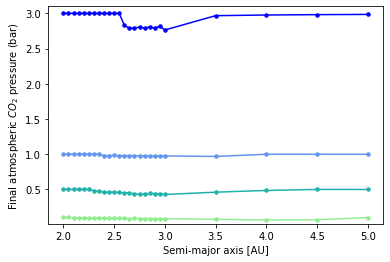

In [23]:
colori = ['blue','cornflowerblue','lightseagreen','lightgreen','tomato']

for i in range(len(a0_plot)-1):
    plt.plot(a0_plot[i,:],CO2_atm[i,:],color=colori[i],linewidth='1.5')
    plt.scatter(a0_plot[i,:],CO2_atm[i,:],s=12,color=colori[i])
#plt.semilogy()
plt.ylim([0.01,3.1])
#plt.ylabel('$p_{CO_{2,final}}/p_{CO_{2,initial}}$ [bar]')
plt.ylabel('Final atmospheric $CO_{2}$ pressure (bar)')
plt.xlabel('Semi-major axis [AU]')
plt.savefig('CO2_end.pdf')    
plt.show()

In [50]:
# What is the temperature gradient across the planet?
start = ["Warm"] 
STAR = ["F0","Sun","K5"] 
smass = ["1.5","1.0","0.6"]

# Figure 4
a0 = ["2.5","1.25","0.53"]

obl = ["0.","23.5"]
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["1.0"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

temp_ave = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
temp_mi = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
temp_ma = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
latitude_plot = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
CO2_ice = np.zeros((nbelts,len(a0)*2),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for b in range(len(obl)):
    for c in range(len(STAR)):
            if b==0:
                #val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            else:
                # val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            print (icoldflag,obl[b],a0[c],pco2i,ocean,igeog,STAR[c],smass[c],val[c])
            obl_t = obl[b]
            
            with open("input_ebm.dat", "r") as f:
                main = f.read()
                for j, line in enumerate(splitfile):
                    if var[0] in line:
                        splitfile[j] = 'icoldflag:       %s' % icoldflag[0]
                    if var[1] in line:
                        splitfile[j] = 'obl:             %s' % obl[b]
                    if var[2] in line:
                        splitfile[j] = 'a0:              %s' % a0[c]            
                    if var[3] in line:
                        splitfile[j] = 'pco2i:           %s' % pco2i[0] 
                    if var[4] in line:
                        splitfile[j] = 'ocean:           %s' % ocean[0]            
                    if var[5] in line:
                        splitfile[j] = 'igeog:           %s' % igeog[0]   
                    if var[6] in line:
                        splitfile[j] = 'STAR:      %s' % STAR[c]
                    if var[7] in line:
                        splitfile[j] = 'smass:           %s' % smass[c]    
                    if var[8] in line:
                        splitfile[j] = 'val:     %s' % val[c] 
        
                with open("input_ebm.dat", "w") as f:
                    f.write('\n'.join(splitfile))              

        
                if j==0:
                    subprocess.call(['make clean'], shell=True)
                    subprocess.call(['make'], shell=True)
            
                subprocess.call(['./driver'],shell=True)
            
                df = pd.read_csv('out/model.out', header=None)
                df = pd.DataFrame(df[0].str.split(' ').tolist())
        
                #Average temperature from text file
                temp_av = df.iloc[56:72,14]
                temp_av = temp_av.append(df.iloc[72:74,15])
                temp_av = temp_av.append(df.iloc[74:76,16])
                temp_av = temp_av.append(df.iloc[76:92,15])
                temp_av = np.array(temp_av, dtype = np.float32)
                
                print ("Average temperatures", temp_av)
                
                pCO2_final = df.iloc[47,8]
                print ("Final atmospheric CO2 atmospheric pressure =", pCO2_final)
                
                #Minimum temperature from text file
                temp_min = df.iloc[56:72,20]
                temp_min = temp_min.append(df.iloc[72:74,21])
                temp_min = temp_min.append(df.iloc[74:76,22])
                temp_min = temp_min.append(df.iloc[76:92,21])
                temp_min = np.array(temp_min, dtype = np.float32)
                
                temp_max = df.iloc[56:72,25]
                temp_max = temp_max.append(df.iloc[72:74,26])
                temp_max = temp_max.append(df.iloc[74:76,27])
                temp_max = temp_max.append(df.iloc[76:92,26])
                temp_max = np.array(temp_max, dtype = np.float32)
                
                print ("Minimum temperatures", temp_min)
                print ("Maximum temperatures", temp_max)
                
                latitude = df.iloc[56:72,4]
                latitude = latitude.append(df.iloc[72:74,5])
                latitude = latitude.append(df.iloc[74:76,6])
                latitude = latitude.append(df.iloc[76:92,5])
                latitude = np.array(latitude, dtype = np.float32)
                
                temp_ave[:,n] = temp_av
                temp_ma[:,n] = temp_max
                temp_mi[:,n] = temp_min
                latitude_plot[:,n]=latitude
                
                # CO2 surface ice
                for m in range(len(df)):
                    if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                        CO2_ice[n,s] = df.iloc[m,10]
                        break
                    elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                        CO2_ice[n,s] = df.iloc[m,9]
                    if CO2_ice[n,s]<0:
                        exit
                        break
                print ("Fraction of CO2 lost to the surface =", CO2_ice[n,s]) 

                n+=1

['0'] 0. 2.5 ['1.0'] ['0.7'] ['1'] F0 1.5 0.001
Average temperatures [270.919 271.245 272.082 273.48  275.17  277.079 279.254 281.504 283.765
 285.999 288.062 290.    291.746 293.236 294.443 295.324 295.996 296.251
 296.245 295.806 295.057 294.    292.678 291.018 289.25  287.254 285.176
 282.98  280.73  278.485 276.315 274.42  272.735 271.327 270.434 270.063]
Final atmospheric CO2 atmospheric pressure = 1.00000E+00
Minimum temperatures [270.884 271.223 272.124 273.444 275.137 277.112 279.271 281.517 283.784
 285.991 288.083 290.007 291.73  293.218 294.437 295.365 295.978 296.265
 296.219 295.815 295.071 294.004 292.644 291.05  289.251 287.268 285.147
 282.939 280.689 278.466 276.337 274.39  272.717 271.346 270.418 270.075]
Maximum temperatures [270.88 271.22 272.12 273.44 275.14 277.11 279.27 281.52 283.78 285.99
 288.08 290.01 291.73 293.22 294.44 295.36 295.98 296.27 296.22 295.82
 295.07 294.   292.64 291.05 289.25 287.27 285.15 282.94 280.69 278.47
 276.34 274.39 272.72 271.35 270.

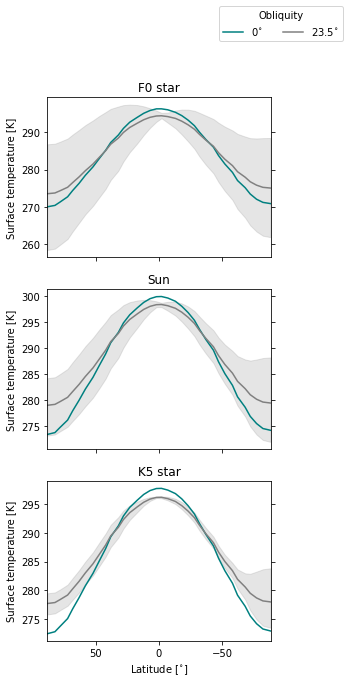

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(4, 10), sharex=True)
for i in range(temp_ave.shape[1]):
        
    latitude = latitude_plot[:,i]

stars=["F0 star", "Sun", "K5 star"]
for i in range(3):
    #ax[i].fill_between(latitude,temp_mi[:,i],temp_ma[:,i],color='teal',alpha=0.2)
    ax[i].fill_between(latitude,temp_mi[:,i+3],temp_ma[:,i+3],color='grey',alpha=0.2)
    av_lowobl=ax[i].plot(latitude,temp_ave[:,i],color='teal',label='$0^{\circ}$')
    av_highobl=ax[i].plot(latitude,temp_ave[:,i+3],color='grey',label='$23.5^{\circ}$')
    ax[i].set_xlim([88, -88])
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_ylabel("Surface temperature [K]")
    ax[i].set_title('{}'.format(stars[i]))
ax[0].legend(title='Obliquity',ncol=len(df.columns),loc=(0.77,1.35))
plt.setp(av_lowobl[1:], label="_")
plt.setp(av_highobl[1:], label="_")
plt.xlabel("Latitude [$^{\circ}$]")
plt.savefig('Figures/shading_icold{}_a{}.pdf'.format(icoldflag[0],a0[0]), bbox_inches='tight',format='pdf')
plt.show()